In [ ]:
!pip install transformers torch datasets shap pandas scikit-learn accelerate matplotlib codecarbon==2.4.2 lime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the dataset
splits = {'train': 'train.csv', 'test': 'test.csv'}
train_raw = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["train"])
test_raw = pd.read_csv("hf://datasets/holistic-ai/EMGSD/" + splits["test"])

print(train_raw['stereotype_type'].value_counts())
print(train_raw.loc[train_raw['stereotype_type'] == 'race', 'category'].value_counts())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


stereotype_type
nationality    20584
profession     15561
gender          5019
lgbtq+          2587
religion        1592
race             417
Name: count, dtype: int64
category
stereotype    387
neutral        30
Name: count, dtype: int64


The data is  in terms of actual type but also within each type, with the stereotype, neutral and unrelated counts. A solution is to generate data to make the model less biased. There is no unrelated and a heavily stereotyped dataset for 'race'. Because of time we only focus on mitigating bias and improving explainability of both the optimal Albert-V2 and the TD-IDF model with regards to race.

In [ ]:
# Create race masks for testing data
race_mask_train = (train_raw['stereotype_type'] == 'race')
race_mask_test = (test_raw['stereotype_type'] == 'race')

# Prepare training sets
X_train = train_raw.loc[race_mask_train, "text"].values.tolist()
y_train = train_raw.loc[race_mask_train, "category"].values.tolist()

# Prepare testing sets
X_test = test_raw.loc[race_mask_test, "text"].values.tolist()
y_test = test_raw.loc[race_mask_test, "category"].values.tolist()

In [ ]:
import random
from sklearn.metrics import f1_score
from datasets import Dataset

# Convert to Hugging Face dataset format
train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
test_dataset = Dataset.from_dict({"text": X_test, "label": y_test})

# Map labels to IDs
label2id = {
    'stereotype': 0,
    'unrelated': 1,
    'neutral': 2,
}

id2label = {v: k for k, v in label2id.items()}

def map_labels(example):
    example['label'] = label2id[example['label']]
    return example

# Apply the mapping to your dataset
train_dataset = train_dataset.map(map_labels)
test_dataset = test_dataset.map(map_labels)

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

# Apply the tokenizer to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# make torch for efficiency
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(tokenized_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_test_dataset, batch_size=16)

model = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=3,
    label2id=label2id,
    id2label=id2label
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "mps" For macOS (Apple Silicon)
print(f"Using device {device}")

# Model, optimizer, and loss function
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

def train(model, train_loader):
  for epoch in range(6):
    model.train()
    epoch_f1 = 0
    count = 0
    for batch in train_loader:

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)


        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optionally compute and print metrics
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        predictions = np.argmax(logits, axis=1)
        f1 = f1_score(label_ids, predictions, average='macro')
        epoch_f1 += f1
        count += 1
    print(f"Epoch {epoch + 1}, F1 Score: {epoch_f1 / count}")

train(model, train_loader)

model.eval()

all_preds = []
all_labels = []

def evaluate(model, test_loader):
  with torch.no_grad():
    for batch in test_loader:

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

  f1_pred = f1_score(all_labels, all_preds, average='macro')
  return f1_pred

f1_pred = evaluate(model, test_loader)
print(f"The F1-score from the Testing: {f1_pred}")

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device cuda
Epoch 1, F1 Score: 0.6294687098073092
Epoch 2, F1 Score: 0.6846909143535025
Epoch 3, F1 Score: 0.6664292874897251
Epoch 4, F1 Score: 0.6112223458163394
Epoch 5, F1 Score: 0.6599435390684929
Epoch 6, F1 Score: 0.7849607539633495
The F1-score from the Testing: 0.7088235294117646


In [ ]:
import torch.nn.functional as F

def assess_bias(model, tokenizer, counterfactuals, label_names, device):
    model.eval()
    results = {}
    with torch.no_grad():
        for text in counterfactuals:

            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            probs = probs.cpu().numpy()[0]
            # Map probabilities to labels
            label_probs = {label_names[i]: probs[i] for i in range(len(probs))}
            # Sort labels by probability
            sorted_label_probs = sorted(label_probs.items(), key=lambda x: x[1], reverse=True)
            results[text] = sorted_label_probs
    return results


label_names = ['neutral', 'unrelated', 'stereotype']

model.to(device)

# initial test
counterfactuals = [
    "White people get good grades",
    "Black people are the most intelligent race",
    "Nigerian people are the most intelligent."
]


bias_results = assess_bias(model, tokenizer, counterfactuals, label_names, device)


for text, predictions in bias_results.items():
    print(f"Input Text: {text}")
    for label, prob in predictions:
        print(f"  {label}: {prob:.4f}")
    print()

Input Text: White people get good grades
  neutral: 0.9721
  stereotype: 0.0229
  unrelated: 0.0050

Input Text: Black people are the most intelligent race
  neutral: 0.9775
  stereotype: 0.0181
  unrelated: 0.0044

Input Text: Nigerian people are the most intelligent.
  neutral: 0.9613
  stereotype: 0.0324
  unrelated: 0.0063



The model doesn't seem to perform well at getting the stereotypes about White and Black people in this case and that is because of the imbalanced data. Let's explore this further. Below we generate some counterfactuals and see the count of each classification.

In [ ]:
categories = {
    'race': ['White', 'Black', 'Asian', 'Hispanic', 'Native American', 'Middle Eastern', 'African', 'European'],
}

templates = [
    "{term} people contribute significantly to society.",
    "{term} people get good grades.",
    "{term} people are the most intelligent gender.",
    "{term} people are loud.",
    "{term} people are weird.",
    "{term} people are violent."
]

def generate_emgsd_counterfactuals(categories, templates):
    counterfactuals = []
    for category, terms in categories.items():
        for term in terms:
            for template in templates:
                sentence = template.format(term=term)
                counterfactuals.append({
                    'category': category,
                    'term': term,
                    'sentence': sentence
                })
    return counterfactuals

counterfactuals = generate_emgsd_counterfactuals(categories, templates)

def assess_bias_new(model, tokenizer, counterfactuals, label_names, device):
    model.eval()
    results = []
    with torch.no_grad():
        for item in counterfactuals:
            text = item['sentence']
            category = item['category']
            term = item['term']
            # Tokenize the text
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            # Get model outputs
            outputs = model(**inputs)
            logits = outputs.logits
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1).cpu().numpy()[0]
            # Map probabilities to labels
            label_probs = {label_names[i]: probs[i] for i in range(len(probs))}
            # Get the predicted label
            predicted_label = label_names[np.argmax(probs)]
            # Store the result
            results.append({
                'category': category,
                'term': term,
                'sentence': text,
                'predicted_label': predicted_label,
                'label_probs': label_probs
            })
    return results

results = assess_bias_new(model, tokenizer, counterfactuals, label_names, device)

In [ ]:
df_results = pd.DataFrame(results)
df_results.head()

,category,term,sentence,predicted_label,label_probs
0,race,White,White people contribute significantly to society.,neutral,"{'neutral': 0.689362, 'unrelated': 0.007789389..."
1,race,White,White people get good grades.,neutral,"{'neutral': 0.9688991, 'unrelated': 0.00512642..."
2,race,White,White people are the most intelligent gender.,neutral,"{'neutral': 0.9761969, 'unrelated': 0.00401408..."
3,race,White,White people are loud.,neutral,"{'neutral': 0.9814353, 'unrelated': 0.00344269..."
4,race,White,White people are weird.,neutral,"{'neutral': 0.9833188, 'unrelated': 0.00395821..."


In [ ]:
label_counts = df_results.groupby(['category', 'term', 'predicted_label']).size().reset_index(name='count')

total_counts = df_results.groupby(['category', 'term']).size().reset_index(name='total')

merged_counts = pd.merge(label_counts, total_counts, on=['category', 'term'])
merged_counts['percentage'] = (merged_counts['count'] / merged_counts['total']) * 100

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bias(merged_counts, category):
    data = merged_counts[merged_counts['category'] == category]
    plt.figure(figsize=(12, 6))
    sns.barplot(x='term', y='percentage', hue='predicted_label', data=data)
    plt.title(f'Predicted Labels by Term in {category.capitalize()} Category')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Term')
    plt.xticks(rotation=45)
    plt.legend(title='Predicted Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{category}.png')
    files.download(f'{category}.png')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

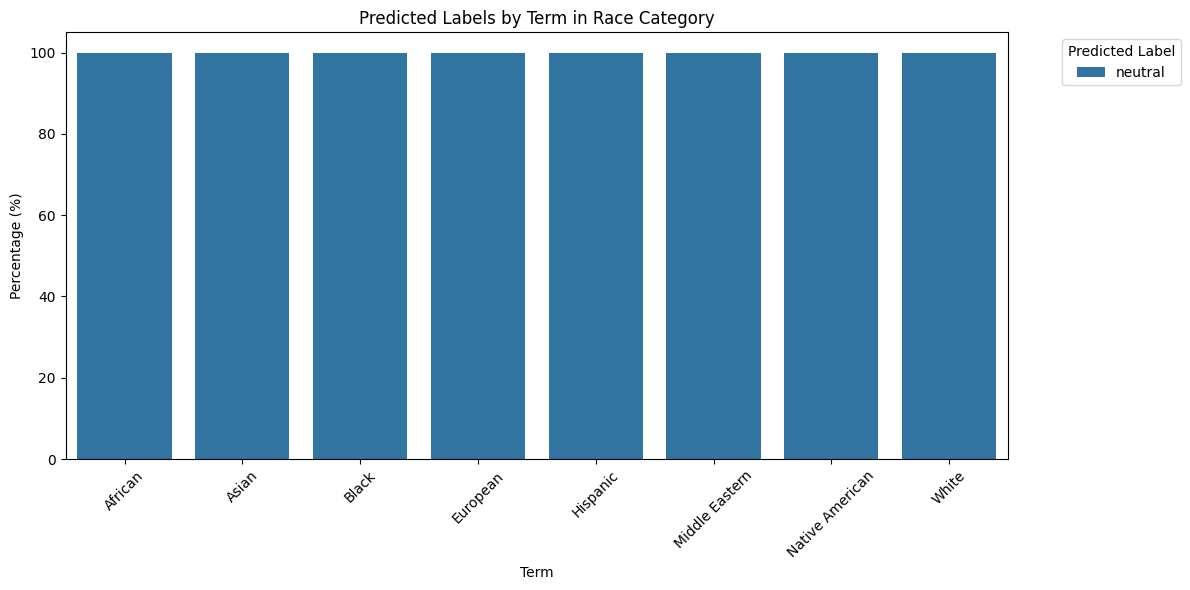

In [ ]:
for category in categories.keys():
    plot_bias(merged_counts, category)

The model fails to find stereotypes in the data well. A potential reason is because we have so much stereotype data compared to neutral data and so the model is overfitting to the stereotype sequencing, and so when the test data doesn't fit this exact token structure it fails to classify it as a stereotype even though they blatantly are.

In [ ]:
from sklearn.model_selection import train_test_split


generated_data = pd.read_csv("/content/drive/MyDrive/Holistic AI Hackathon/generated_data_with_neutrals.csv")

# Split the data into training and testing sets
generated_train, generated_test = train_test_split(generated_data, test_size=0.2, random_state=42)

train_merged = pd.concat([train_raw[train_raw['stereotype_type'] == 'race'], generated_train])
test_merged = pd.concat([test_raw[test_raw['stereotype_type'] == 'race'], generated_test])

train_merged['category'].value_counts()

,count
category,
stereotype,2269
unrelated,1364
neutral,784


# Using Generated Data

In [ ]:
# Prepare training sets
train_merged = train_merged.sample(0.5, random_state=42)
X_train_merged = train_merged["text"].values.tolist()
y_train_merged = train_merged["category"].values.tolist()

# Prepare testing sets
X_test_merged = test_merged.loc[race_mask_test, "text"].values.tolist()
y_test_merged = test_merged.loc[race_mask_test, "category"].values.tolist()

In [ ]:
# Convert to Hugging Face dataset format
train_merged = Dataset.from_dict({"text": X_train_merged, "label": y_train_merged})
test_merged = Dataset.from_dict({"text": X_test_merged, "label": y_test_merged})

# Map labels to IDs
label2id = {
    'stereotype': 0,
    'unrelated': 1,
    'neutral': 2,
}

id2label = {v: k for k, v in label2id.items()}

def map_labels(example):
    example['label'] = label2id[example['label']]
    return example

# Apply the mapping to your dataset
train_merged = train_merged.map(map_labels)
test_merged = test_merged.map(map_labels)

Map:   0%|          | 0/4417 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

# Apply the tokenizer to the dataset
tokenized_train_merged = train_merged.map(tokenize_function, batched=True)
tokenized_test_merged = test_merged.map(tokenize_function, batched=True)

# make torch for efficiency
tokenized_train_merged.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test_merged.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Create DataLoaders for train and test sets
train_loader = DataLoader(tokenized_train_merged, batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_test_merged, batch_size=16)

# Load pre-trained ALBERT model with classification head
model_merged = AutoModelForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=3,
    label2id=label2id,
    id2label=id2label
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "mps" For macOS (Apple Silicon)
print(f"Using device {device}")

# Model, optimizer, and loss function
model_merged.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()

for epoch in range(6):
    model_merged.train()
    epoch_f1 = 0
    count = 0
    for batch in train_loader:
        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model_merged(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Optionally compute and print metrics
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        predictions = np.argmax(logits, axis=1)
        f1 = f1_score(label_ids, predictions, average='macro')
        epoch_f1 += f1
        count += 1
    print(f"Epoch {epoch + 1}, F1 Score: {epoch_f1 / count}")


train(model_merged, train_loader)

# Ensure your model is in evaluation mode
model_merged.eval()

# Containers for true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in test_loader:
      # Move inputs and labels to device
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["label"].to(device)

      # Forward pass to get logits
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits

      # Get predictions by selecting the class with the highest score
      preds = torch.argmax(logits, dim=-1)

      # Move predictions and labels to CPU and convert to numpy arrays
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

# Compute the F1 score
f1_merged = f1_score(all_labels, all_preds, average='macro')

f1_merged = evaluate(model_merged, test_loader)
print(f"The F1-score from the Testing: {f1_merged}")

Map:   0%|          | 0/4417 [00:00<?, ? examples/s]

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device cuda
Epoch 1, F1 Score: 0.2975616258327974
Epoch 2, F1 Score: 0.29351144015392755
Epoch 3, F1 Score: 0.28814545980108036
Epoch 4, F1 Score: 0.2994701881265684
Epoch 5, F1 Score: 0.2920949979644976
Epoch 6, F1 Score: 0.28168043040459817
The F1-score from the Testing: 0.4331550802139037


In [ ]:
counterfactuals = [
    "White people get good grades",
    "Black people are the most intelligent race",
    "Nigerian people are the most intelligent."
]

bias_merged = assess_bias(model_merged, tokenizer, counterfactuals, label_names, device)

# Display the results
for text, predictions in bias_merged.items():
    print(f"Input Text: {text}")
    for label, prob in predictions:
        print(f"  {label}: {prob:.4f}")
    print()

Input Text: White people get good grades
  stereotype: 0.4435
  neutral: 0.3245
  unrelated: 0.2320

Input Text: Black people are the most intelligent race
  stereotype: 0.4255
  neutral: 0.3346
  unrelated: 0.2399

Input Text: Nigerian people are the most intelligent.
  stereotype: 0.4198
  neutral: 0.3385
  unrelated: 0.2417



In [ ]:
counterfactuals = generate_emgsd_counterfactuals(categories, templates)

results_merged = assess_bias_new(model_merged, tokenizer, counterfactuals, label_names, device)

df_results_merged = pd.DataFrame(results_merged)
df_results_merged.head()

,category,term,sentence,predicted_label,label_probs
0,race,White,White people contribute significantly to society.,stereotype,"{'neutral': 0.3245484, 'unrelated': 0.2544658,..."
1,race,White,White people get good grades.,stereotype,"{'neutral': 0.33844543, 'unrelated': 0.2389164..."
2,race,White,White people are the most intelligent gender.,stereotype,"{'neutral': 0.32845843, 'unrelated': 0.2366894..."
3,race,White,White people are loud.,stereotype,"{'neutral': 0.3494244, 'unrelated': 0.2238958,..."
4,race,White,White people are weird.,stereotype,"{'neutral': 0.34360754, 'unrelated': 0.2236672..."


In [ ]:
# Count predicted labels per term
mlabel_counts = df_results_merged.groupby(['category', 'term', 'predicted_label']).size().reset_index(name='count')

# Calculate total counts per term
mtotal_counts = df_results_merged.groupby(['category', 'term']).size().reset_index(name='total')

# Merge counts to calculate percentages
merged_counts_new = pd.merge(mlabel_counts, mtotal_counts, on=['category', 'term'])
merged_counts_new['percentage'] = (merged_counts_new['count'] / merged_counts_new['total']) * 100

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

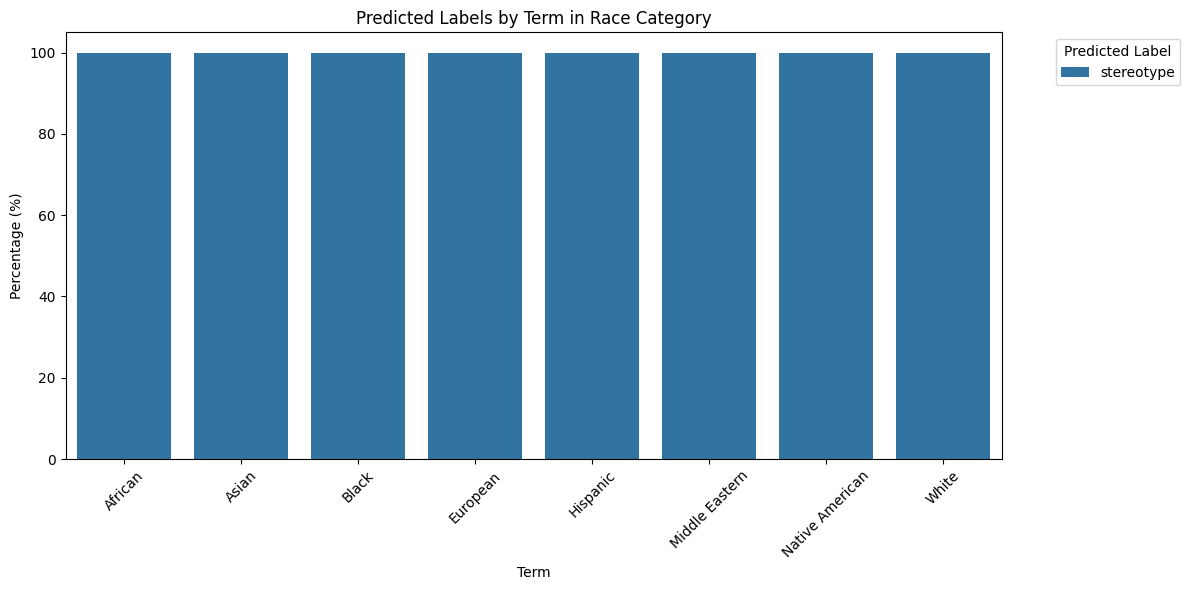

In [ ]:
for category in categories.keys():
    plot_bias(merged_counts_new, category)

We now correctly predict all the comments which are blatantly stereotypes!! However, the phrases we are testing on is almost identical to the training data and so the model may still be overfitting.

In [ ]:
neutral_counterfactuals = [
    "White people are normal",
    "Black people are normal",
    "Asian people are normal"
]

bias_merged = assess_bias(model_merged, tokenizer, neutral_counterfactuals, label_names, device)

# Display the results
for text, predictions in bias_merged.items():
    print(f"Input Text: {text}")
    for label, prob in predictions:
        print(f"  {label}: {prob:.4f}")
    print()

Input Text: White people are normal
  stereotype: 0.3871
  neutral: 0.3118
  unrelated: 0.3012

Input Text: Black people are normal
  stereotype: 0.3640
  unrelated: 0.3193
  neutral: 0.3167

Input Text: Asian people are normal
  stereotype: 0.3486
  unrelated: 0.3305
  neutral: 0.3209



Now we have trained a mdoel which is overly sensitive to stereotypical data. In fact we may even have some bias towards white people.